## Importing Libraries

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms
import torchvision
from torch.hub import load_state_dict_from_url
import matplotlib.pyplot as plt
import pandas as pd
import os
import PIL
from torchvision.io import read_image
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import random


In [2]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

In [3]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Extracting Data
!unzip /content/drive/MyDrive/CSCI_677/data_semantics.zip

Archive:  /content/drive/MyDrive/CSCI_677/data_semantics.zip
   creating: testing/
   creating: testing/image_2/
  inflating: testing/image_2/000000_10.png  
  inflating: testing/image_2/000001_10.png  
  inflating: testing/image_2/000002_10.png  
  inflating: testing/image_2/000003_10.png  
  inflating: testing/image_2/000004_10.png  
  inflating: testing/image_2/000005_10.png  
  inflating: testing/image_2/000006_10.png  
  inflating: testing/image_2/000007_10.png  
  inflating: testing/image_2/000008_10.png  
  inflating: testing/image_2/000009_10.png  
  inflating: testing/image_2/000010_10.png  
  inflating: testing/image_2/000011_10.png  
  inflating: testing/image_2/000012_10.png  
  inflating: testing/image_2/000013_10.png  
  inflating: testing/image_2/000014_10.png  
  inflating: testing/image_2/000015_10.png  
  inflating: testing/image_2/000016_10.png  
  inflating: testing/image_2/000017_10.png  
  inflating: testing/image_2/000018_10.png  
  inflating: testing/image_2/000

In [5]:
# Extracting Data
!unzip /content/drive/MyDrive/CSCI_677/devkit_semantics.zip

Archive:  /content/drive/MyDrive/CSCI_677/devkit_semantics.zip
  inflating: README.md               
   creating: devkit/
   creating: devkit/evaluation/
 extracting: devkit/evaluation/__init__.py  
  inflating: devkit/evaluation/__init__.pyc  
  inflating: devkit/evaluation/addToConfusionMatrix.c  
  inflating: devkit/evaluation/addToConfusionMatrix.pyx  
  inflating: devkit/evaluation/addToConfusionMatrix.so  
  inflating: devkit/evaluation/addToConfusionMatrix_impl.c  
  inflating: devkit/evaluation/evalInstanceLevelSemanticLabeling.py  
  inflating: devkit/evaluation/evalInstanceLevelSemanticLabeling.pyc  
  inflating: devkit/evaluation/evalPixelLevelSemanticLabeling.py  
  inflating: devkit/evaluation/instance.py  
  inflating: devkit/evaluation/instance.pyc  
  inflating: devkit/evaluation/instances2dict.py  
  inflating: devkit/evaluation/instances2dict.pyc  
  inflating: devkit/evaluation/setup.py  
   creating: devkit/helpers/
 extracting: devkit/helpers/__init__.py  
  inflat

## Loading Dataset

In [113]:
class KittiDataset(Dataset):
    def __init__(self, img_list, img_dir, mask_dir, transform=None):
        self.img_labels = img_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = transforms.Compose([ 
                                                  transforms.Resize((360,1200),transforms.InterpolationMode.NEAREST),
                                                  transforms.PILToTensor(),    
                                                  ])
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        mask_path = os.path.join(self.mask_dir, self.img_labels[idx])
        image = PIL.Image.open(img_path)
        mask = PIL.Image.open(mask_path).convert("L")
        if self.transform:
            image = self.transform(image)
            mask = self.mask_transform(mask).long()
        return image, mask

In [114]:
i_path = "/content/training/image_2"
s_path = "/content/training/semantic" 


data_sz = len(os.listdir(i_path))
train_data = sorted(os.listdir(i_path))[:int(data_sz*.7)] # using 70% training
val_data = sorted(os.listdir(i_path))[int(data_sz*.7):int(data_sz*.85)] # using 15% validation
test_data =  sorted(os.listdir(i_path))[int(data_sz*.85):] # using 15% test
transform = transforms.Compose([
    transforms.Resize((360,1200),transforms.InterpolationMode.NEAREST), # resizing images to 224x224
    transforms.Pad(100),  #padding image by 100 on each side
    transforms.ToTensor(),    # scaling images between [0,1]
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Using ImageNet mean and std
])


In [115]:
# Creating train, val, and test data
train = KittiDataset(train_data,i_path,s_path,transform)
val = KittiDataset(val_data,i_path,s_path,transform)
test = KittiDataset(test_data,i_path,s_path,transform)


In [116]:
# define the data loaders
BATCH_SIZE = 8
train_loader = DataLoader(dataset=train, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,num_workers=2,pin_memory=True)
valid_loader = DataLoader(dataset=val, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False,num_workers=2,pin_memory=True)
test_loader = DataLoader(dataset=test, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False,num_workers=2,pin_memory=True)

# Main Experiment

## Model 1: Creating FCN32 Architecture 

In [117]:
class FCN32(nn.Module):
    def __init__(self, num_classes=35):
        super(FCN32, self).__init__()
        pretrained_net = torchvision.models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(pretrained_net.children())[:-2]) #removing last 2 fc layers
        self.other_layers = nn.Sequential(
            nn.AvgPool2d(kernel_size = 7,stride = 1),
            nn.Conv2d( in_channels = 512, out_channels = num_classes, kernel_size = 1),
            nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64,stride=32)
        )
        
    def forward(self, x):
        h = x
        h = self.backbone(h)
        h = self.other_layers(h)
        h = h[:, :, 19:19 + x.size()[2]-200, 19:19 + x.size()[3]-200].contiguous() # minus 200 to account for the initial padding
        return h

In [118]:
model = FCN32().to(device) 
print(model) 

FCN32(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [119]:
# torch.cuda.empty_cache()

In [120]:
# initalizing learning rate
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate) # using adam optimizer
scheduler = optim.lr_scheduler.StepLR(optimizer,20,0.5) # scheduler to decreate learning rate by half after every 20 epochs


## Training the Neural Network

In [121]:
def compute_IoU(cm): # function to compute mean IoU and pixel level IoU
    
    sum_over_row = cm.sum(axis=0)
    sum_over_col = cm.sum(axis=1)
    true_positives = np.diag(cm)

    denominator = sum_over_row + sum_over_col - true_positives
    with np.errstate(divide='ignore', invalid='ignore'):
      iou = true_positives / denominator
    return iou, np.nanmean(iou) 


In [122]:
def train_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, epochs=10):
  train_losses = []
  valid_losses = []
  train_mIoU = []
  val_mIoU = []


  # Train model
  for epoch in range(0, epochs):

      # training    
      model.train()
      epoch_loss = 0
      cm = np.zeros((35,35)) # initalize confusion matrix
      
      for data, labels in train_loader:
          
          # zero the parameter gradients
          optimizer.zero_grad()
          
          data = data.to(device)
          labels = labels.to(device).squeeze(1)
          
          # Forward pass
          pred = model(data)
          loss = criterion(pred, labels) 
          epoch_loss += loss.item() * pred.shape[0]
          pred = pred.argmax(dim=1)
          for j in range(len(labels)): 
                true = labels[j].cpu().detach().numpy().flatten()
                pred_i = pred[j].cpu().detach().numpy().flatten()
                cm += confusion_matrix(true, pred_i, labels=np.arange(35))
          
          # Backward pass
          loss.backward()
          optimizer.step()
      
      scheduler.step()

       # calcuating training loss adn IoU for each epoch  
      train_loss = epoch_loss / len(train_loader.dataset)
      train_losses.append(train_loss)
      tclass_iou, tmean_iou = compute_IoU(cm)
      train_mIoU.append(tmean_iou)

      

          # validation
      with torch.no_grad():        
          model.eval()
          epoch_loss = 0
          cm = np.zeros((35,35))

          for data, labels in valid_loader:
      
              data = data.to(device)
              labels = labels.to(device).squeeze(1)
              # Forward pass and record loss
              pred = model(data) 
              loss = criterion(pred, labels) 
              epoch_loss += loss.item()*pred.shape[0]
              pred = pred.argmax(dim=1)
              for j in range(len(labels)): 
                true = labels[j].cpu().detach().numpy().flatten()
                pred_i = pred[j].cpu().detach().numpy().flatten()
                cm += confusion_matrix(true, pred_i, labels=np.arange(35))

          # calculating validation loss and IoU
          valid_loss = epoch_loss / len(valid_loader.dataset)
          valid_losses.append(valid_loss)
          vclass_iou, vmean_iou = compute_IoU(cm)
          val_mIoU.append(vmean_iou)

      if epoch % 5 == 4:  # printing a summary after every 5 epochs          
          print(f'Epoch: {epoch+1}\t Train loss: {train_loss:.4f} \t Valid loss: {valid_loss:.4f}\t Train mIoU: {tmean_iou:.4f} \t Valid mIoU: {vmean_iou:.4f}\n')

  return model, optimizer, train_losses, valid_losses, train_mIoU, val_mIoU

In [123]:
model, optimizer, train_losses, valid_losses, train_mIoU, val_mIoU= train_model(model, criterion, optimizer,scheduler, train_loader, valid_loader, 40)

Epoch: 5	 Train loss: 0.9030 	 Valid loss: 1.4955	 Train mIoU: 0.1157 	 Valid mIoU: 0.0770

Epoch: 10	 Train loss: 0.7275 	 Valid loss: 1.1555	 Train mIoU: 0.1564 	 Valid mIoU: 0.1325

Epoch: 15	 Train loss: 0.5797 	 Valid loss: 1.0562	 Train mIoU: 0.2382 	 Valid mIoU: 0.1586

Epoch: 20	 Train loss: 0.5950 	 Valid loss: 1.1389	 Train mIoU: 0.2371 	 Valid mIoU: 0.1442

Epoch: 25	 Train loss: 0.4689 	 Valid loss: 0.9690	 Train mIoU: 0.3247 	 Valid mIoU: 0.1622

Epoch: 30	 Train loss: 0.4323 	 Valid loss: 0.9745	 Train mIoU: 0.3570 	 Valid mIoU: 0.1615

Epoch: 35	 Train loss: 0.4048 	 Valid loss: 0.9694	 Train mIoU: 0.3569 	 Valid mIoU: 0.1650

Epoch: 40	 Train loss: 0.3824 	 Valid loss: 1.0038	 Train mIoU: 0.3881 	 Valid mIoU: 0.1757



In [124]:
# Function for plotting training and validation losses   
def plot_losses(train_losses, valid_losses,filename=None):

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, label='Training loss') 
    ax.plot(valid_losses, label='Validation loss')
    ax.set(title="Loss Graph", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    if filename:
      plt.savefig(filename)

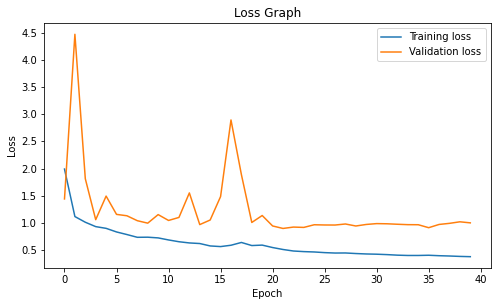

In [125]:
plot_losses(train_losses,valid_losses,"Loss_Main_FCN32.jpg") # plotting loss graph for FCN32

In [126]:
# Function for plotting training and validation IoU   
def plot_mIoU(train_mIoU, val_mIoU,filename=None):

    train_mIoU = np.array(train_mIoU) 
    val_mIoU = np.array(val_mIoU)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_mIoU, label='Training Mean Iou') 
    ax.plot(val_mIoU, label='Validation Mean Iou')
    ax.set(title="Mean IoU Graph", 
            xlabel='Epoch',
            ylabel='mIoU') 
    ax.legend()
    fig.show()
    if filename:
      plt.savefig(filename)

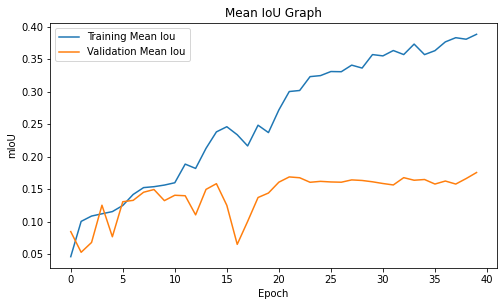

In [127]:
plot_mIoU(train_mIoU,val_mIoU,"mIoU_Main_FCN32.jpg") # plotting IoU graph for FCN32

In [128]:
# Function for computing the pixel level IoU and Mean IOU over an entire dataset
def get_IoU(model, dataset, device):

    cm = np.zeros((35,35)) #initalize confusion matrix

    with torch.no_grad():
      model.eval()
 
      for i in range(len(dataset)):
          data,labels = dataset[i]
          data = data.to(device)
          labels = labels.to(device)
          pred = model(data.unsqueeze(0))
          pred = pred.argmax(dim=1)
          true = labels.cpu().detach().numpy().flatten()
          pred_i = pred.cpu().detach().numpy().flatten()
          cm += confusion_matrix(true, pred_i, labels=np.arange(35))

    class_iou, mean_iou = compute_IoU(cm) # calculating IoU

    print(f"Mean IoU: {mean_iou:.4f} ")
    # print IoU for each class
    for clas, iou in enumerate(class_iou):
        print(f"IoU for class {clas} is: {iou:.4f} ")

In [129]:
# Calculating per calss IoU for each class in train, val and test sets
# print('train IoU:')
# get_IoU(model,train,device)
print('validation IoU:')
get_IoU(model,val,device)
print('test IoU:')
get_IoU(model,test,device)


validation IoU:
Mean IoU: 0.1757 
IoU for class 0 is: 0.0000 
IoU for class 1 is: nan 
IoU for class 2 is: nan 
IoU for class 3 is: nan 
IoU for class 4 is: 0.0893 
IoU for class 5 is: 0.0000 
IoU for class 6 is: 0.0000 
IoU for class 7 is: 0.7325 
IoU for class 8 is: 0.2997 
IoU for class 9 is: 0.2515 
IoU for class 10 is: 0.0252 
IoU for class 11 is: 0.6320 
IoU for class 12 is: 0.0000 
IoU for class 13 is: 0.1543 
IoU for class 14 is: nan 
IoU for class 15 is: 0.0000 
IoU for class 16 is: nan 
IoU for class 17 is: 0.0552 
IoU for class 18 is: nan 
IoU for class 19 is: 0.0005 
IoU for class 20 is: 0.0558 
IoU for class 21 is: 0.7702 
IoU for class 22 is: 0.5808 
IoU for class 23 is: 0.6883 
IoU for class 24 is: 0.0000 
IoU for class 25 is: 0.0000 
IoU for class 26 is: 0.5854 
IoU for class 27 is: 0.0000 
IoU for class 28 is: 0.0000 
IoU for class 29 is: 0.0000 
IoU for class 30 is: 0.0000 
IoU for class 31 is: 0.0000 
IoU for class 32 is: 0.0000 
IoU for class 33 is: 0.0000 
IoU for 

In [130]:
# Colourmap for plotting 
cmap =    {
     0  : (  0,  0,  0) ,
     1  : (  0,  0,  0) ,
     2  : (  0,  0,  0) ,
     3  : (  0,  0,  0) ,
     4  : (  0,  0,  0) ,
     5  : (111, 74,  0) ,
     6  : ( 81,  0, 81) ,
     7  : (128, 64,128) ,
     8  : (244, 35,232) ,
     9  : (250,170,160) ,
    10  : (230,150,140) ,
    11  : ( 70, 70, 70) ,
    12  : (102,102,156) ,
    13  : (190,153,153) ,
    14  : (180,165,180) ,
    15  : (150,100,100) ,
    16  : (150,120, 90) ,
    17  : (153,153,153) ,
    18  : (153,153,153) ,
    19  : (250,170, 30) ,
    20  : (220,220,  0) ,
    21  : (107,142, 35) ,
    22  : (152,251,152) ,
    23  : ( 70,130,180) ,
    24  : (220, 20, 60) ,
    25  : (255,  0,  0) ,
    26  : (  0,  0,142) ,
    27  : (  0,  0, 70) ,
    28  : (  0, 60,100) ,
    29  : (  0,  0, 90) ,
    30  : (  0,  0,110) ,
    31  : (  0, 80,100) ,
    32  : (  0,  0,230) ,
    33  : (119, 11, 32) ,
    34  : (255, 255, 255) ,
    }

In [147]:
# Plotting randomly few images with correct and predicted labels
def plot_predictions(mod,dataset,ftitle,filename,ROW_IMG = 2,N_ROWS = 3):

  fig = plt.figure(figsize=(20,14))
  for index in range(1, ROW_IMG * N_ROWS + 1,2):
      plt.subplot(N_ROWS, ROW_IMG, index)
      plt.axis('off')
      with torch.no_grad():        
        mod.eval()
        data = dataset[index][0].to(device)
        labels = dataset[index][1].to(device)
        pred = mod(data.unsqueeze(0))
      pp = pred.argmax(dim=1)
      pp = pp.reshape(pp.shape[1], pp.shape[2])
      tp = labels.reshape(labels.shape[1], labels.shape[2])
      pim = np.array(list(cmap.values()))[pp.to('cpu')]
      piml = np.array(list(cmap.values()))[tp.to('cpu')]
      plt.imshow(pim)
      title = f"Predicted Image {index//2+1}"
      plt.title(title, fontsize=13)
      plt.subplot(N_ROWS, ROW_IMG, index+1)
      plt.axis('off')
      plt.imshow(piml)
      title = f"True Image {index//2+1}"
      plt.title(title, fontsize=13)
  fig.suptitle(ftitle, fontsize=15)
  fig.tight_layout()
  if filename:
        fig.savefig(filename)
  fig.show()

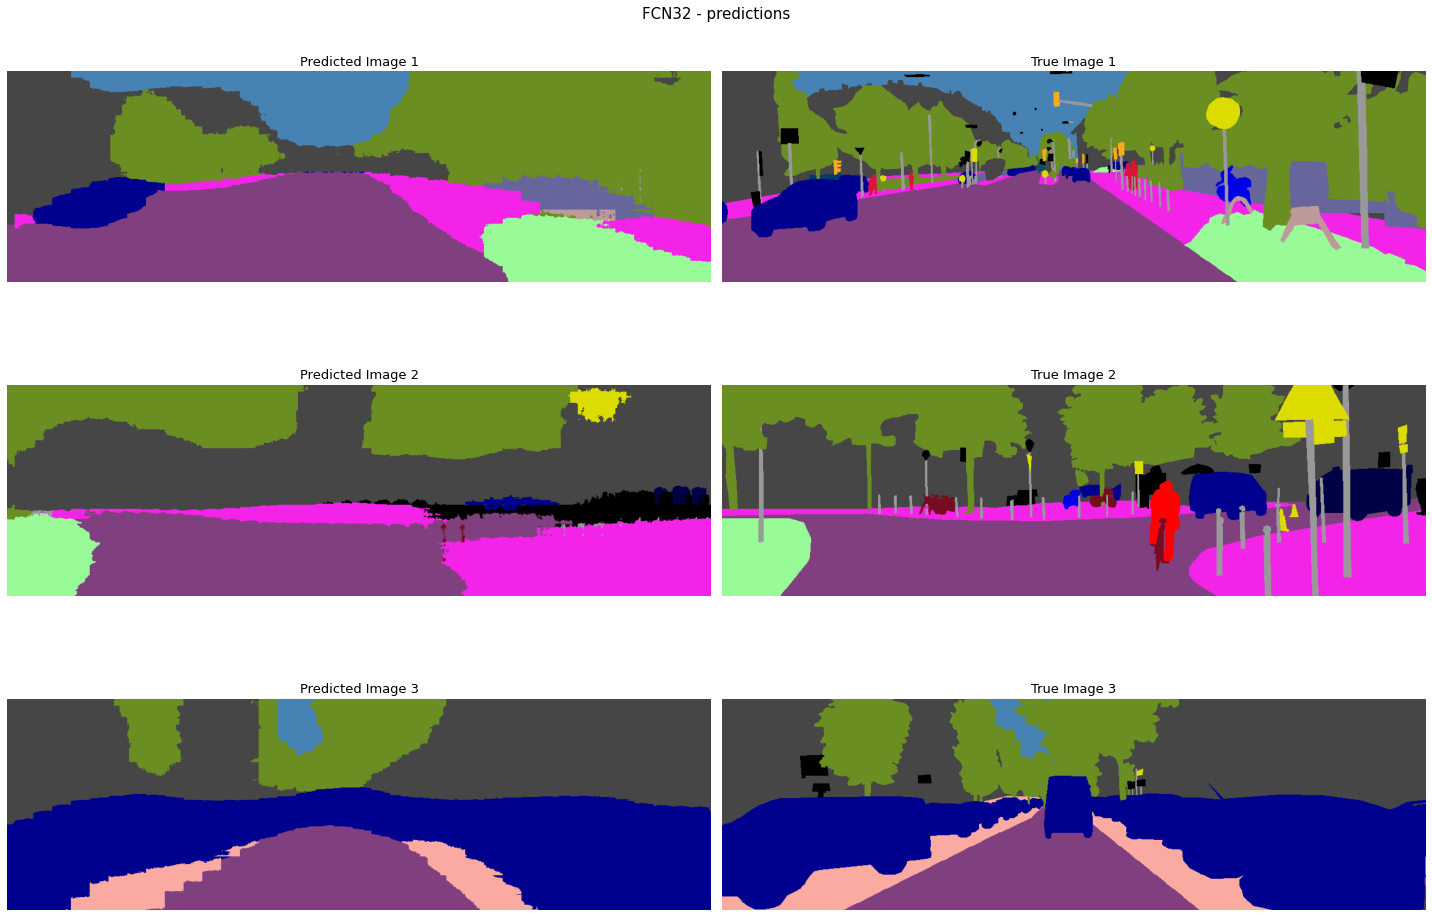

In [150]:
plot_predictions(model,train,'FCN32 - predictions','FCN32_predictions.jpg')

## Model 2: FCN16 Architecture

In [151]:
class FCN16(nn.Module):
    def __init__(self, num_classes=35):
        super(FCN16, self).__init__()
        pretrained_net = torchvision.models.resnet18(pretrained=True) # using resnet18 as backbone
        self.backbone = nn.Sequential(*list(pretrained_net.children())[:-2])
                
         # To get output of last and 2nd last layer of resnet18       
        self.intermediate_m = torchvision.models._utils.IntermediateLayerGetter(self.backbone,{'6': 'layer6', '7': 'layer7'})
  
        self.other_layers = nn.Sequential(
            nn.AvgPool2d(kernel_size = 7,stride = 1),
            nn.Conv2d( in_channels = 512, out_channels = num_classes, kernel_size = 1),
            nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4,stride=2)
        )
        self.score_pool4 = nn.Conv2d( in_channels = 256, out_channels = num_classes, kernel_size = 1)
        self.upscore16 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=32, stride=16)
        
    def forward(self, x):
        h = x
        h=self.intermediate_m(h)
        upscore2 = self.other_layers(h['layer7']) # Upscaling the output of last layer by 2
        interLayer = self.score_pool4(h['layer6']) #extracting the output of 2nd last layer
        score_pool4c = interLayer[:, :, 5:5 + upscore2.size()[2], 5:5 + upscore2.size()[3]].contiguous() #slicing s.t. both output have same shape
        h = upscore2 + score_pool4c # adding both outputs
        h = self.upscore16(h) # upscaling the combined output
        h = h[:, :, 27:27 + x.size()[2]-200, 27:27 + x.size()[3]-200].contiguous()
        return h

In [152]:
model_fcn16 = FCN16().to(device)
print(model_fcn16)

FCN16(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [153]:
# torch.cuda.empty_cache()

In [154]:
# Defining optimizer and scheduler
optimizer_fcn16 = optim.AdamW(model_fcn16.parameters(), lr=learning_rate)
scheduler_fcn16 = optim.lr_scheduler.StepLR(optimizer_fcn16,20,0.5)

#training the model

model_fcn16, optimizer_fcn16, train_losses_fcn16, valid_losses_fcn16, train_mIoU_fcn16, val_mIoU_fcn16 = train_model(model_fcn16, criterion, optimizer_fcn16, scheduler_fcn16, train_loader, valid_loader, 40)

Epoch: 5	 Train loss: 0.8114 	 Valid loss: 1.4650	 Train mIoU: 0.1245 	 Valid mIoU: 0.0797

Epoch: 10	 Train loss: 0.7114 	 Valid loss: 1.3515	 Train mIoU: 0.1394 	 Valid mIoU: 0.1154

Epoch: 15	 Train loss: 0.5217 	 Valid loss: 0.9626	 Train mIoU: 0.1989 	 Valid mIoU: 0.1595

Epoch: 20	 Train loss: 0.4112 	 Valid loss: 0.8462	 Train mIoU: 0.2624 	 Valid mIoU: 0.1866

Epoch: 25	 Train loss: 0.3268 	 Valid loss: 0.9359	 Train mIoU: 0.3300 	 Valid mIoU: 0.1815

Epoch: 30	 Train loss: 0.2842 	 Valid loss: 0.8914	 Train mIoU: 0.4093 	 Valid mIoU: 0.1962

Epoch: 35	 Train loss: 0.2525 	 Valid loss: 0.9132	 Train mIoU: 0.4399 	 Valid mIoU: 0.1939

Epoch: 40	 Train loss: 0.2120 	 Valid loss: 0.8674	 Train mIoU: 0.4806 	 Valid mIoU: 0.2083



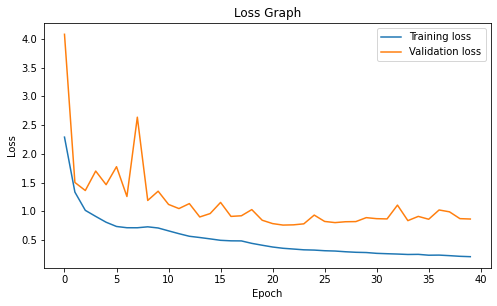

In [155]:
# plotting the loss graph
plot_losses(train_losses_fcn16, valid_losses_fcn16,"Loss_Main_FCN16.jpg") # plotting loss graph for FCN16


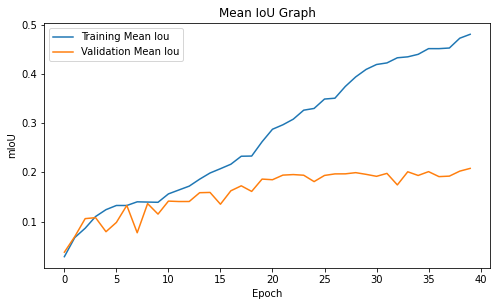

In [156]:
plot_mIoU(train_mIoU_fcn16,val_mIoU_fcn16,"mIoU_Main_FCN16.jpg") # plotting IoU graph for FCN16


In [157]:
# Calculating per calss IoU for each class in train, val and test sets
# print('train IoU:')
# get_IoU(model,train,device)
print('validation IoU:')
get_IoU(model_fcn16,val,device)
print('test IoU:')
get_IoU(model_fcn16,test,device)


validation IoU:
Mean IoU: 0.2083 
IoU for class 0 is: 0.0000 
IoU for class 1 is: nan 
IoU for class 2 is: nan 
IoU for class 3 is: nan 
IoU for class 4 is: 0.1225 
IoU for class 5 is: 0.0000 
IoU for class 6 is: 0.0000 
IoU for class 7 is: 0.7769 
IoU for class 8 is: 0.3648 
IoU for class 9 is: 0.2286 
IoU for class 10 is: 0.2793 
IoU for class 11 is: 0.6996 
IoU for class 12 is: 0.0000 
IoU for class 13 is: 0.1232 
IoU for class 14 is: 0.0000 
IoU for class 15 is: 0.0000 
IoU for class 16 is: nan 
IoU for class 17 is: 0.1593 
IoU for class 18 is: nan 
IoU for class 19 is: 0.0654 
IoU for class 20 is: 0.1522 
IoU for class 21 is: 0.8699 
IoU for class 22 is: 0.6955 
IoU for class 23 is: 0.8435 
IoU for class 24 is: 0.0013 
IoU for class 25 is: 0.0000 
IoU for class 26 is: 0.6465 
IoU for class 27 is: 0.0061 
IoU for class 28 is: 0.0000 
IoU for class 29 is: 0.0000 
IoU for class 30 is: 0.0000 
IoU for class 31 is: 0.0000 
IoU for class 32 is: 0.0000 
IoU for class 33 is: 0.0054 
IoU f

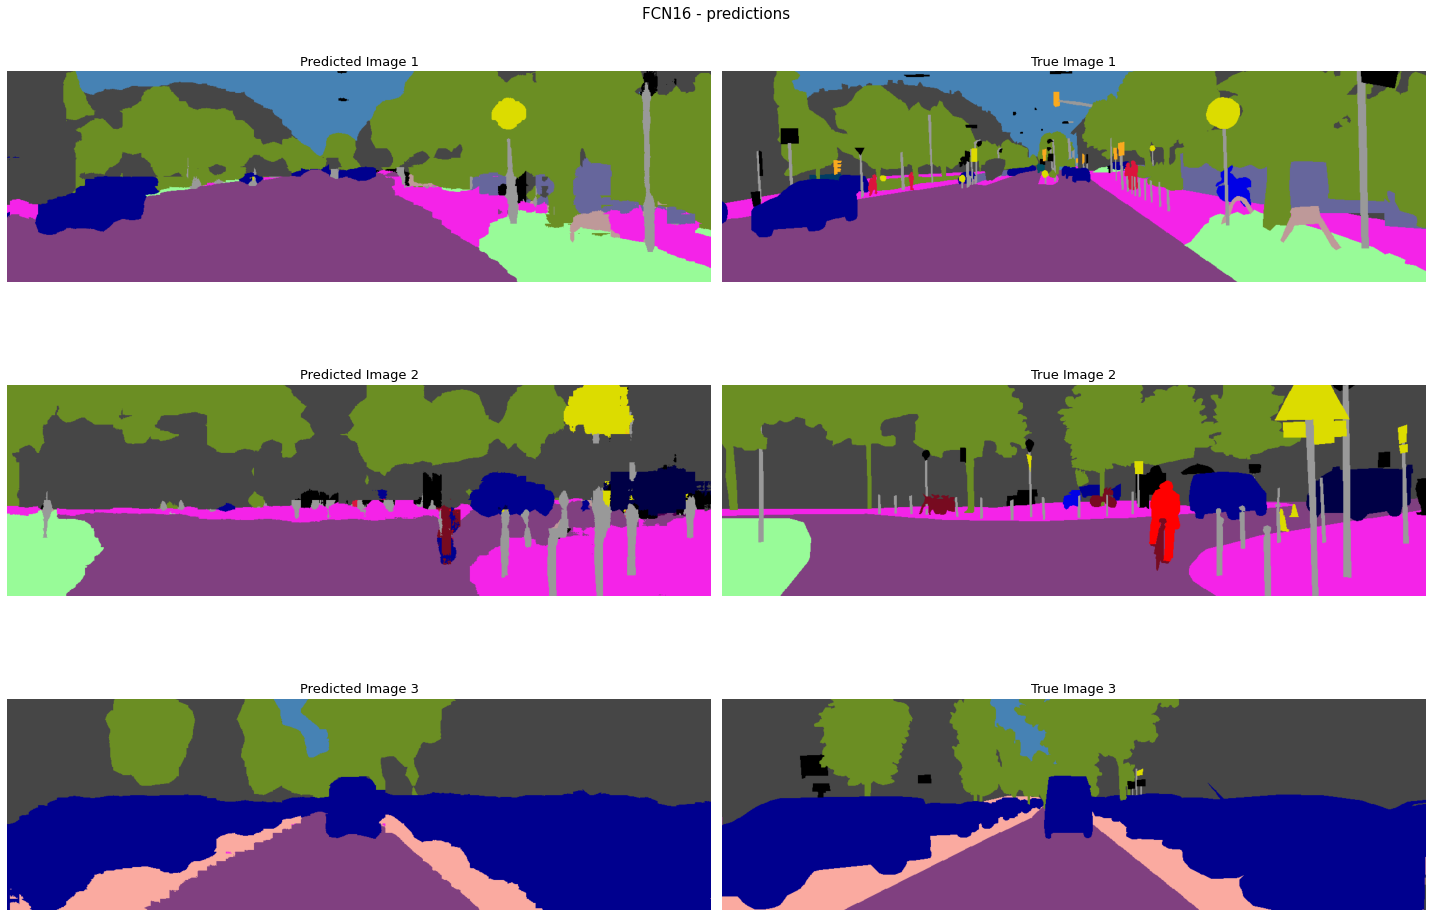

In [158]:
plot_predictions(model_fcn16,train,'FCN16 - predictions','FCN16_predictions.jpg')